In [1]:
import sys
sys.path.append('../')
# import our own functions
from utils import *
# for preprocessing
import pandas as pd
pd.set_option('display.max_columns', None)
pd.option_context("display.max_rows", None)
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
from scipy.special import inv_boxcox
from sklearn import preprocessing as ps
from sklearn.impute import KNNImputer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_excel("../../01_Data/02_Processed/processed_v3.xlsx")
df.head()

,FACUL_NUM,DIVISION_NUM,TAG,SEGMENT_LOB,UF_STATUS,CT_STATUS,UWYEAR,CT_PERIOD,MARKET,MAIN_COUNTRY,SUBSECTOR,MAINOCCUPANCY,BUSINESSUNIT,UWCENTER,COVERAGE,PARTTYPE,GUARANTEE,MAIN_PRICING_CATEG,MAIN_PRICING_SUBCATEG,BI_TYPE,BI_PERIOD,INSUREDVALUEPD,INSUREDVALUEBI,TOTALINSUREDVALUE,NBLOCS,OIL,LIMIT,ATTACHMENT,SCOR_SHARE,PREMIUM,MODELED_CAT_EXPLOSS,DISCOUNTS,DEDUCTION,EXT_EXPENSE,WORDING,QUALITY_RISK_MGT,ASSET_QUALITY,BI_MITIGATION,MB_QUALITY,ORIGCCY,TXCHANGE,FXRATEUSD,TOP_MPL,TOP_FMLS,pd_bi,pd,bi,inception_year,inception_month,inception_duration,pricing_duration,diff,premium_level,UWR_cumultive,UWR_avg,UWY_first,YEAR,nb_state,ACCURACY_VALIDATE,YR_BLT,NO_OF_STRY,NO_OF_BLDG,IV_BUILDING,IV_CONTENT,IV_PD,IV_BI_VAL,TIV,INTEREST_DECLARATION,MPL_PD,MPL_PD_PERCEN,MPL_BI,MPL_BI_PERCEN,FMLS_PD,FMLS_PD_PERCEN,FMLS_BI,FMLS_BI_PERCEN,nb_category,LARGEST_UNIT_CAPACITY,EARTHQ_EXP,CYC_EXP,CYCPRO_EXP,FLD_EXP,MHZ_EXP,MHZPRO_EXP,VOL_EXP
0,02F062851,4,Bound,Ppty Non Energy,Active,Finalized,2019,12,ARGENTINA,Argentina,MINING COMPANY,Precious Metals Mines,BS Energy Mining,EMEA,"PD,BI",Excess of Loss,Unspecified,Mining - Hard Rock,Standard,Loss of profit,12.0,4.33e+08,1.81e+08,6.14e+08,1,0.0,3.59e+08,6.60e+06,0.10,51556.79,0.0,0.0,0.09,0.09,Standard,Average,Average,Average,NaN,USD,0.88,1.0,1.99e+08,NaN,NaN,0.9,30.0,2019,4,707,739,32,< 60K,0.46,6.88,12,2019,1,1.0,0.0,0,0,9.92e+08,5.13e+09,6.12e+09,2.31e+09,7.68e+09,19.0,2.00e+07,0.21,1.08e+07,5.26,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,69.63,0.0,69.63,0.0
1,11F008861,1,Bound,Ppty Non Energy,Active,Finalized,2017,12,CANADA,Argentina,MINING COMPANY,Precious Metals Mines,BS Energy Mining,CANADA,"PD,BI",Quota-Share,Unspecified,Mining - Hard Rock,Standard,Loss of profit,12.0,5.37e+08,1.64e+08,7.01e+08,3,0.0,1.86e+08,0.00e+00,0.07,101618.14,0.0,0.0,0.12,0.12,Standard,Average,Average,Average,NaN,USD,0.93,1.0,1.86e+08,NaN,NaN,0.5,30.0,2017,4,1408,1427,19,60K ~ 220K,0.07,0.47,5,2017,3,1.0,0.0,0,0,2.79e+08,2.99e+08,5.78e+08,1.76e+08,7.55e+08,3.0,2.89e+08,50.00,5.87e+07,100.00,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0
2,02F062851,4,Bound,Ppty Non Energy,Active,Finalized,2018,12,ARGENTINA,Argentina,MINING COMPANY,Precious Metals Mines,BS Energy Mining,EMEA,"PD,BI",Excess of Loss,Unspecified,Mining - Hard Rock,Standard,Loss of profit,12.0,4.18e+08,2.40e+08,6.58e+08,1,0.0,3.43e+08,6.32e+06,0.10,45815.49,0.0,0.0,0.13,0.13,Standard,Average,Average,Average,NaN,USD,0.84,1.0,2.57e+08,NaN,NaN,0.8,30.0,2018,3,1103,1103,0,< 60K,0.46,6.88,12,2018,1,1.0,0.0,0,0,9.43e+08,4.88e+09,5.82e+09,2.35e+09,6.79e+09,18.0,2.00e+07,0.22,1.58e+07,5.56,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,69.52,0.0,69.52,0.0
3,FA0020462,1,Bound,Ppty Non Energy,Active,Finalized,2018,12,CANADA,Argentina,MINING COMPANY,Precious Metals Mines,BS Energy Mining,CANADA,"PD,BI",Quota-Share,Unspecified,Mining - Hard Rock,Standard,Loss of profit,12.0,4.90e+08,2.27e+08,7.17e+08,3,0.0,1.68e+08,0.00e+00,0.03,35547.13,0.0,0.0,0.11,0.11,Standard,Average,Average,Average,NaN,USD,0.84,1.0,2.29e+08,NaN,NaN,0.4,30.0,2018,6,982,983,1,< 60K,0.08,0.40,5,2018,3,1.0,0.0,0,0,9.31e+07,4.89e+08,5.82e+08,2.70e+08,8.52e+08,3.0,2.91e+08,50.00,8.99e+07,100.00,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0
4,02F062851,4,Bound,Ppty Non Energy,Active,Finalized,2017,12,ARGENTINA,Argentina,MINING COMPANY,Precious Metals Mines,BS Energy Mining,EMEA,"PD,BI",Excess of Loss,Unspecified,Mining - Hard Rock,Standard,Loss of profit,12.0,4.53e+08,2.53e+08,7.06e+08,1,0.0,3.79e+08,6.97e+06,0.10,69669.24,0.0,0.0,0.14,0.14,Standard,Average,Average,Average,NaN,USD,0.93,1.0,2.35e+08,NaN,NaN,0.9,30.0,2017,3,1468,1469,1,60K ~ 220K,0.46,6.88,12,2017,1,1.0,0.0,0,0,1.33e+09,6.12e+09,7.45e+09,2.93e+09,8.54e+09,23.0,4.88e+07,0.43,8.89e+06,3.26,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,81.98,0.0,75.56,0.0


In [3]:
print(df.shape)
summary(df)

(5192, 85)


,Type,unique value,Available Value,% Availability
Column name,,,,
FACUL_NUM,object,3017,5192,100.00
DIVISION_NUM,int64,12,5192,100.00
TAG,object,4,5192,100.00
SEGMENT_LOB,object,2,5192,100.00
UF_STATUS,object,4,5192,100.00
CT_STATUS,object,3,5192,100.00
UWYEAR,int64,4,5192,100.00
CT_PERIOD,int64,23,5192,100.00
MARKET,object,128,5192,100.00


In [4]:
df = df[df.SCOR_SHARE < 1]
df[['TOP_FMLS','pd_bi','FMLS_PD_PERCEN','FMLS_BI_PERCEN']] = df[['TOP_FMLS','pd_bi',
                                                                 'FMLS_PD_PERCEN','FMLS_BI_PERCEN']].fillna(0)

## Encoding categorical variables with hashing
#### ! As ensemble regression models are sensitive to sparsity of the data, hashing or label encoding gave us better performance than One-Hot encoding

In [5]:
f = df[['MAIN_PRICING_CATEG','MAIN_PRICING_SUBCATEG','SUBSECTOR']]
f2 = df[['MARKET','MAIN_PRICING_SUBCATEG']]
feature_hash(df, f, max_size=60)
feature_hash(df, f2, max_size=30)
df.drop(['MARKET','MAIN_PRICING_CATEG','MAIN_PRICING_SUBCATEG','SUBSECTOR'], axis=1, inplace=True)

In [6]:
df.head()

,FACUL_NUM,DIVISION_NUM,TAG,SEGMENT_LOB,UF_STATUS,CT_STATUS,UWYEAR,CT_PERIOD,MAIN_COUNTRY,MAINOCCUPANCY,BUSINESSUNIT,UWCENTER,COVERAGE,PARTTYPE,GUARANTEE,BI_TYPE,BI_PERIOD,INSUREDVALUEPD,INSUREDVALUEBI,TOTALINSUREDVALUE,NBLOCS,OIL,LIMIT,ATTACHMENT,SCOR_SHARE,PREMIUM,MODELED_CAT_EXPLOSS,DISCOUNTS,DEDUCTION,EXT_EXPENSE,WORDING,QUALITY_RISK_MGT,ASSET_QUALITY,BI_MITIGATION,MB_QUALITY,ORIGCCY,TXCHANGE,FXRATEUSD,TOP_MPL,TOP_FMLS,pd_bi,pd,bi,inception_year,inception_month,inception_duration,pricing_duration,diff,premium_level,UWR_cumultive,UWR_avg,UWY_first,YEAR,nb_state,ACCURACY_VALIDATE,YR_BLT,NO_OF_STRY,NO_OF_BLDG,IV_BUILDING,IV_CONTENT,IV_PD,IV_BI_VAL,TIV,INTEREST_DECLARATION,MPL_PD,MPL_PD_PERCEN,MPL_BI,MPL_BI_PERCEN,FMLS_PD,FMLS_PD_PERCEN,FMLS_BI,FMLS_BI_PERCEN,nb_category,LARGEST_UNIT_CAPACITY,EARTHQ_EXP,CYC_EXP,CYCPRO_EXP,FLD_EXP,MHZ_EXP,MHZPRO_EXP,VOL_EXP,MAIN_PRICING_CATEG_hash,MAIN_PRICING_SUBCATEG_hash,SUBSECTOR_hash,MARKET_hash
0,02F062851,4,Bound,Ppty Non Energy,Active,Finalized,2019,12,Argentina,Precious Metals Mines,BS Energy Mining,EMEA,"PD,BI",Excess of Loss,Unspecified,Loss of profit,12.0,4.33e+08,1.81e+08,6.14e+08,1,0.0,3.59e+08,6.60e+06,0.10,51556.79,0.0,0.0,0.09,0.09,Standard,Average,Average,Average,NaN,USD,0.88,1.0,1.99e+08,0.0,0.0,0.9,30.0,2019,4,707,739,32,< 60K,0.46,6.88,12,2019,1,1.0,0.0,0,0,9.92e+08,5.13e+09,6.12e+09,2.31e+09,7.68e+09,19.0,2.00e+07,0.21,1.08e+07,5.26,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,69.63,0.0,69.63,0.0,22,16,16,15
1,11F008861,1,Bound,Ppty Non Energy,Active,Finalized,2017,12,Argentina,Precious Metals Mines,BS Energy Mining,CANADA,"PD,BI",Quota-Share,Unspecified,Loss of profit,12.0,5.37e+08,1.64e+08,7.01e+08,3,0.0,1.86e+08,0.00e+00,0.07,101618.14,0.0,0.0,0.12,0.12,Standard,Average,Average,Average,NaN,USD,0.93,1.0,1.86e+08,0.0,0.0,0.5,30.0,2017,4,1408,1427,19,60K ~ 220K,0.07,0.47,5,2017,3,1.0,0.0,0,0,2.79e+08,2.99e+08,5.78e+08,1.76e+08,7.55e+08,3.0,2.89e+08,50.00,5.87e+07,100.00,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,22,16,16,1
2,02F062851,4,Bound,Ppty Non Energy,Active,Finalized,2018,12,Argentina,Precious Metals Mines,BS Energy Mining,EMEA,"PD,BI",Excess of Loss,Unspecified,Loss of profit,12.0,4.18e+08,2.40e+08,6.58e+08,1,0.0,3.43e+08,6.32e+06,0.10,45815.49,0.0,0.0,0.13,0.13,Standard,Average,Average,Average,NaN,USD,0.84,1.0,2.57e+08,0.0,0.0,0.8,30.0,2018,3,1103,1103,0,< 60K,0.46,6.88,12,2018,1,1.0,0.0,0,0,9.43e+08,4.88e+09,5.82e+09,2.35e+09,6.79e+09,18.0,2.00e+07,0.22,1.58e+07,5.56,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,69.52,0.0,69.52,0.0,22,16,16,15
3,FA0020462,1,Bound,Ppty Non Energy,Active,Finalized,2018,12,Argentina,Precious Metals Mines,BS Energy Mining,CANADA,"PD,BI",Quota-Share,Unspecified,Loss of profit,12.0,4.90e+08,2.27e+08,7.17e+08,3,0.0,1.68e+08,0.00e+00,0.03,35547.13,0.0,0.0,0.11,0.11,Standard,Average,Average,Average,NaN,USD,0.84,1.0,2.29e+08,0.0,0.0,0.4,30.0,2018,6,982,983,1,< 60K,0.08,0.40,5,2018,3,1.0,0.0,0,0,9.31e+07,4.89e+08,5.82e+08,2.70e+08,8.52e+08,3.0,2.91e+08,50.00,8.99e+07,100.00,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,22,16,16,1
4,02F062851,4,Bound,Ppty Non Energy,Active,Finalized,2017,12,Argentina,Precious Metals Mines,BS Energy Mining,EMEA,"PD,BI",Excess of Loss,Unspecified,Loss of profit,12.0,4.53e+08,2.53e+08,7.06e+08,1,0.0,3.79e+08,6.97e+06,0.10,69669.24,0.0,0.0,0.14,0.14,Standard,Average,Average,Average,NaN,USD,0.93,1.0,2.35e+08,0.0,0.0,0.9,30.0,2017,3,1468,1469,1,60K ~ 220K,0.46,6.88,12,2017,1,1.0,0.0,0,0,1.33e+09,6.12e+09,7.45e+09,2.93e+09,8.54e+09,23.0,4.88e+07,0.43,8.89e+06,3.26,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,81.98,0.0,75.56,0.0,22,16,16,15


## Encoding with label encoder

In [7]:
encoder = ps.LabelEncoder()
df['UWCENTER'] = encoder.fit_transform(df['UWCENTER'])
df['SEGMENT_LOB'] = encoder.fit_transform(df['SEGMENT_LOB'])
df['CT_STATUS'] = encoder.fit_transform(df['CT_STATUS'])
df['COVERAGE'] = encoder.fit_transform(df['COVERAGE'])
df['BUSINESSUNIT'] = encoder.fit_transform(df['BUSINESSUNIT'])
df['UF_STATUS'] = encoder.fit_transform(df['UF_STATUS'])

In [8]:
df.drop(['MAINOCCUPANCY','OIL','NO_OF_STRY','pd_bi','FXRATEUSD','FMLS_BI','IV_CONTENT',
         'DISCOUNTS','premium_level','ORIGCCY','WORDING','QUALITY_RISK_MGT','PARTTYPE','FMLS_BI_PERCEN',
         'MB_QUALITY','MAIN_COUNTRY','GUARANTEE','TAG','inception_year','BI_TYPE','inception_duration','inception_month',
         'COVERAGE','YEAR','nb_category','BI_MITIGATION','ASSET_QUALITY','SEGMENT_LOB','CT_STATUS','YR_BLT',
         'NO_OF_BLDG','FLD_EXP','MHZ_EXP','CYC_EXP','CYCPRO_EXP','MHZPRO_EXP','VOL_EXP'], axis=1,inplace=True)

## Fix the skewness of the training data with BoxCox

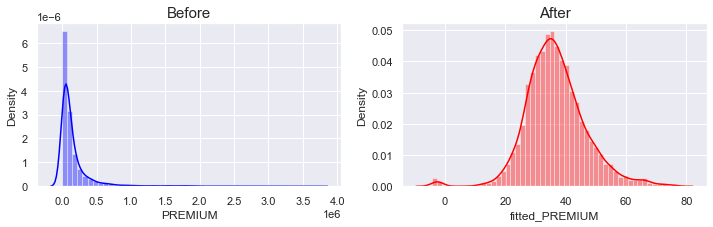

In [9]:
df2 = df
df['fitted_PREMIUM'], lmbda = stats.boxcox(df['PREMIUM'])
fig, ax = plt.subplots(1,2, figsize=(12,3))
sns.distplot(df['PREMIUM'], norm_hist=True, color = 'blue', ax=ax[0]).set_title("Before", fontsize=15)
sns.distplot(df['fitted_PREMIUM'], norm_hist=True, color = 'red', ax=ax[1]).set_title("After", fontsize=15)
plt.show()

In [10]:
df = shuffle(df)
df.drop(['FACUL_NUM','DIVISION_NUM','UWYEAR','PREMIUM'], axis=1, inplace=True)

In [11]:
print(df.shape)
df.head()

(5191, 45)


,UF_STATUS,CT_PERIOD,BUSINESSUNIT,UWCENTER,BI_PERIOD,INSUREDVALUEPD,INSUREDVALUEBI,TOTALINSUREDVALUE,NBLOCS,LIMIT,ATTACHMENT,SCOR_SHARE,MODELED_CAT_EXPLOSS,DEDUCTION,EXT_EXPENSE,TXCHANGE,TOP_MPL,TOP_FMLS,pd,bi,pricing_duration,diff,UWR_cumultive,UWR_avg,UWY_first,nb_state,ACCURACY_VALIDATE,IV_BUILDING,IV_PD,IV_BI_VAL,TIV,INTEREST_DECLARATION,MPL_PD,MPL_PD_PERCEN,MPL_BI,MPL_BI_PERCEN,FMLS_PD,FMLS_PD_PERCEN,LARGEST_UNIT_CAPACITY,EARTHQ_EXP,MAIN_PRICING_CATEG_hash,MAIN_PRICING_SUBCATEG_hash,SUBSECTOR_hash,MARKET_hash,fitted_PREMIUM
1251,0,12,1,4,12.0,4.50e+08,4.65e+07,4.96e+08,65,1.76e+08,0.00e+00,0.15,3964.63,0.06,0.06,0.88,1.70e+08,0.00e+00,0.20,30.0,677,0,4.00e-03,0.02,4,9,0.6,6.79e+07,4.86e+08,5.28e+07,1.93e+08,40.0,4.86e+08,100.0,1.32e+06,91.0,0.00e+00,0.0,0.0,0.0,13,8,9,21,37.43
3073,3,12,2,3,12.0,1.33e+08,2.32e+07,1.56e+08,6,2.61e+07,8.70e+06,0.12,7414.62,0.08,0.08,34.78,4.73e+07,0.00e+00,0.05,15.0,861,1,0.00e+00,0.00,4,1,1.0,3.05e+05,3.81e+06,6.67e+05,4.48e+06,6.0,1.91e+06,50.0,1.11e+05,100.0,0.00e+00,0.0,0.0,0.0,52,18,48,13,30.12
3946,2,12,2,2,24.0,1.16e+09,5.97e+08,1.76e+09,1,9.68e+08,5.72e+08,0.03,0.00,0.00,0.00,0.88,1.76e+09,1.76e+08,NaN,NaN,682,5,0.00e+00,0.00,2,1,1.0,3.83e+08,1.32e+09,6.78e+08,2.00e+09,1.0,1.32e+09,100.0,6.78e+08,100.0,1.32e+08,10.0,0.0,0.0,4,18,3,6,13.83
3584,3,12,2,0,12.0,2.71e+09,3.15e+08,3.03e+09,1,3.03e+09,0.00e+00,0.01,95.00,0.12,0.12,0.01,1.01e+09,9.93e+08,0.10,21.0,1391,-46,0.00e+00,0.00,4,1,1.0,1.98e+10,1.98e+11,2.30e+10,2.21e+11,1.0,6.33e+10,32.0,1.06e+10,46.0,4.95e+10,25.0,0.0,0.0,14,2,3,24,32.84
3615,0,12,2,0,6.0,4.49e+08,2.32e+07,4.72e+08,1,2.79e+08,0.00e+00,0.05,3543.23,0.52,0.52,0.93,3.37e+08,1.35e+08,0.00,7.0,1348,-28,1.45e-02,0.12,2,1,1.0,6.76e+07,4.83e+08,2.50e+07,5.08e+08,1.0,3.38e+08,70.0,2.50e+07,100.0,1.21e+08,25.0,0.0,0.0,4,18,3,15,26.30


## Impute missing data for train / test separately with KNN imputer

In [12]:
train, test = train_test_split(df, test_size=0.12, random_state=123)
knn_imp = KNNImputer(n_neighbors=4, weights='distance')
train_impute = pd.DataFrame(knn_imp.fit_transform(train), columns=df.columns)
test_impute = pd.DataFrame(knn_imp.fit_transform(test), columns=df.columns)

train and test data is quite balanced

In [13]:
X_train = train_impute.drop(['fitted_PREMIUM'], axis=1)
y_train = train_impute['fitted_PREMIUM']
X_test = test_impute.drop(['fitted_PREMIUM'], axis=1)
y_test = test_impute['fitted_PREMIUM']

# Model Training

In [14]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV, KFold
import xgboost
from xgboost import plot_importance
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import tensorflow as tf, keras 
from tensorflow.keras import layers
from keras.layers import Dropout
from tensorflow.keras.layers.experimental import preprocessing
from keras.wrappers.scikit_learn import KerasRegressor
import joblib
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.ensemble import StackingRegressor
import shap
shap.initjs()

In [15]:
X_train.drop(['UF_STATUS','FMLS_PD_PERCEN','TIV','ACCURACY_VALIDATE','FMLS_PD','MPL_PD','NBLOCS','IV_BI_VAL','diff','MAIN_PRICING_SUBCATEG_hash','IV_PD','SUBSECTOR_hash','BI_PERIOD','CT_PERIOD','nb_state','TOP_FMLS','MPL_BI_PERCEN','UWY_first','UWR_cumultive','pricing_duration'], axis=1, inplace=True)
X_test.drop(['UF_STATUS','FMLS_PD_PERCEN','TIV','ACCURACY_VALIDATE','FMLS_PD','MPL_PD','NBLOCS','IV_BI_VAL','diff','MAIN_PRICING_SUBCATEG_hash','IV_PD','SUBSECTOR_hash','BI_PERIOD','CT_PERIOD','nb_state','TOP_FMLS','MPL_BI_PERCEN','UWY_first','UWR_cumultive','pricing_duration'], axis=1, inplace=True)
#X_impute.drop(['UF_STATUS','FMLS_PD_PERCEN','TIV','ACCURACY_VALIDATE','FMLS_PD','MPL_PD','NBLOCS','IV_BI_VAL','diff','MAIN_PRICING_SUBCATEG_hash','IV_PD','SUBSECTOR_hash','BI_PERIOD','CT_PERIOD','nb_state','TOP_FMLS','MPL_BI_PERCEN','UWY_first','UWR_cumultive','pricing_duration'], axis=1, inplace=True)

## XGBoost

In [16]:
xgb = xgboost.XGBRegressor(max_depth=4, n_estimators=700, eta=0.2, grow_policy='lossguide',
                           max_leaves=5, reg_lambda=0, reg_alpha=3, eval_metric=["rmse"]).fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)

In [17]:
y_test_ = inv_boxcox(y_test, 0.17700863235182274)
pred_xgb_ = inv_boxcox(pred_xgb, 0.17700863235182274)

In [18]:
xgb_rmse = np.sqrt(mean_squared_error(y_test, pred_xgb))
print("RMSE: %f" % (xgb_rmse))
minmax = max(df['fitted_PREMIUM']) - min(df['fitted_PREMIUM'])
xgb_nrmse = xgb_rmse / minmax
print("Normalized RMSE: %f" % (xgb_nrmse))

RMSE: 4.009880
Normalized RMSE: 0.049537


In [19]:
xgb_rmse2 = np.sqrt(mean_squared_error(y_test_, pred_xgb_))
print("RMSE: %f" % (xgb_rmse2))
minmax2 = max(df2['PREMIUM']) - min(df2['PREMIUM'])
xgb_nrmse2 = xgb_rmse2 / minmax2
print("Normalized RMSE: %f" % (xgb_nrmse2))

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb.fit(X_train, y_train, eval_metric=["rmse"], eval_set=eval_set, verbose=False)
results = xgb.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.xlabel('Number of estimators',fontsize=18)
plt.ylabel('RMSE',fontsize=18)
plt.title('XGBoost RMSE',fontsize=18)
plt.show()

In [ ]:
weights_xgb = eli5.explain_weights_xgboost(xgb, top=50, feature_names = X_train.columns.tolist())
weights_xgb

## CatBoost

In [ ]:
cb = CatBoostRegressor(iterations=1000, depth=5, l2_leaf_reg=3, learning_rate=0.2, loss_function='RMSE', verbose=False).fit(X_train, y_train,plot=True)
pred_cb = cb.predict(X_test)

In [ ]:
cb_rmse = np.sqrt(mean_squared_error(y_test, pred_cb))
print("RMSE: %f" % (cb_rmse))
cb_nrmse = cb_rmse / minmax
print("Normalized RMSE: %f" % (cb_nrmse))

In [ ]:
pred_cb_ = inv_boxcox(pred_cb, 0.17700863235182274)

In [ ]:
weights_cb = eli5.explain_weights_catboost(cb, top=50, feature_names = X_train.columns.tolist())
weights_cb

In [ ]:
explainer_xgb = shap.TreeExplainer(xgb)
shap_values_xgb = explainer_xgb.shap_values(X_train)
shap.force_plot(explainer_xgb.expected_value, shap_values_xgb[0,:], X_train.iloc[0,:])

In [ ]:
explainer_cb = shap.TreeExplainer(cb)
shap_values_cb = explainer_cb.shap_values(X_train)
shap.force_plot(explainer_cb.expected_value, shap_values_cb[0,:], X_train.iloc[0,:])

In [ ]:
shap.summary_plot(shap_values_xgb, X_train)

In [ ]:
shap.summary_plot(shap_values_cb, X_train)

In [ ]:
shap.dependence_plot('TOTALINSUREDVALUE', shap_values_xgb, X_train)

In [ ]:
shap.dependence_plot('INSUREDVALUEPD', shap_values_cb, X_train)

In [ ]:
shap.dependence_plot('SCOR_SHARE', shap_values_xgb, X_train)

In [ ]:
shap.dependence_plot('MODELED_CAT_EXPLOSS', shap_values_xgb, X_train)

In [ ]:
shap.dependence_plot('MAIN_PRICING_CATEG_hash', shap_values_cb, X_train)

In [ ]:
shap.dependence_plot('ATTACHMENT', shap_values_xgb, X_train, interaction_index=None)

In [ ]:
shap.dependence_plot('BUSINESSUNIT', shap_values_xgb, X_train, interaction_index=None)

In [ ]:
shap.dependence_plot('MARKET_hash', shap_values_xgb, X_train)

In [ ]:
shap.dependence_plot('EARTHQ_EXP', shap_values_xgb, X_train)

In [76]:
def Coef_SHAP(df_shap, df):
    sns.set(font_scale=1.0)
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # check the coeficient direction, and color differently
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr'] > 0, 'lightcoral','skyblue')
    
    # plot
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(4,6),legend=False)
    ax.set_xlabel("Impact to Premium (Red = Positive Impact, Blue = Negative Impact)")
    ax.set_ylabel("")

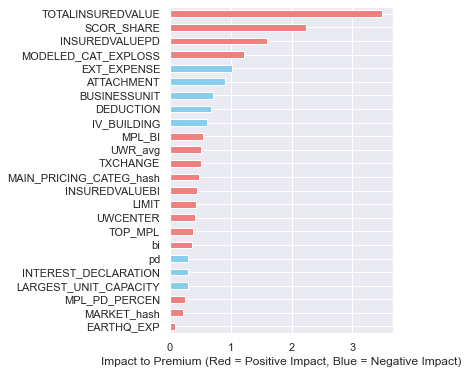

In [77]:
Coef_SHAP(shap_values_xgb, X_train)

## Random Forest

In [81]:
rf = RandomForestRegressor(max_depth=5, min_samples_leaf=3, n_estimators=800).fit(X_train, y_train)
pred_rf = rf.predict(X_test)

In [82]:
rf_rmse = np.sqrt(mean_squared_error(y_test, pred_rf))
print("RMSE: %f" % (rf_rmse))
rf_nrmse = rf_rmse / minmax
print("Normalized RMSE: %f" % (rf_nrmse))

RMSE: 5.626014
Normalized RMSE: 0.069502


In [105]:
pred_rf_ = inv_boxcox(pred_rf, 0.17700863235182274)

In [83]:
perm_rf = PermutationImportance(rf).fit(X_train, y_train)
weights_rf = eli5.show_weights(perm_rf, top=50, feature_names = X_train.columns.tolist())
weights_rf

Weight,Feature
0.6133 ± 0.0240,TOTALINSUREDVALUE
0.1932 ± 0.0098,INSUREDVALUEPD
0.1737 ± 0.0125,SCOR_SHARE
0.0386 ± 0.0041,IV_BUILDING
0.0307 ± 0.0020,ATTACHMENT
0.0224 ± 0.0036,DEDUCTION
0.0207 ± 0.0015,UWR_avg
0.0177 ± 0.0018,EXT_EXPENSE
0.0055 ± 0.0009,bi
0.0053 ± 0.0009,LARGEST_UNIT_CAPACITY


## DNN

In [ ]:
X_train.shape[1]

In [ ]:
normalizer = preprocessing.Normalization(input_shape=(24,))
normalizer.adapt(np.array(X_train))
dnn = keras.Sequential([
    normalizer,
    keras.layers.Dense(40, input_dim=X_train.shape[1], activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1)])
dnn.compile(loss='mean_absolute_error', optimizer='adam',metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
dnn.summary()

In [ ]:
fitted = dnn.fit(X_train, y_train, validation_split=0.10, verbose=0, epochs=80, batch_size=300)
plot_loss(fitted)

In [ ]:
def create_model():
    model = keras.Sequential([
        normalizer,
        keras.layers.Dense(40, input_dim=X_train.shape[1], activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(30, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1)])
    model.compile(loss='mean_absolute_error', optimizer='adam',metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

In [ ]:
pred_dnn = dnn.predict(X_test)
dnn_rmse = np.sqrt(mean_squared_error(y_test, pred_dnn))
print("RMSE: %f" % (dnn_rmse))
dnn_nrmse = dnn_rmse / minmax
print("Normalized RMSE: %f" % (dnn_nrmse))

In [ ]:
dnn2 = KerasRegressor(build_fn=create_model)
dnn2.fit(X_train, y_train, epochs=80, batch_size=300, verbose=0)
perm_dnn = PermutationImportance(dnn2).fit(X_train, y_train)
weights_dnn = eli5.show_weights(perm_dnn, feature_names = X_train.columns.tolist())

In [ ]:
weights_dnn

## Other basic models
### Lasso and Baysian Ridge

In [98]:
ls = linear_model.Lasso(alpha=0.2).fit(X_train, y_train)
pred_ls = ls.predict(X_test)
ls_rmse = np.sqrt(mean_squared_error(y_test, pred_ls))
print("RMSE: %f" % (ls_rmse))
ls_nrmse = ls_rmse / minmax
print("Normalized RMSE: %f" % (ls_nrmse))
perm_ls = PermutationImportance(ls).fit(X_train, y_train)
weights_ls = eli5.show_weights(perm_ls, feature_names = X_train.columns.tolist())
weights_ls

RMSE: 7.453214
Normalized RMSE: 0.092075


Weight,Feature
0.7844 ± 0.0382,TOTALINSUREDVALUE
0.2129 ± 0.0101,INSUREDVALUEPD
0.0951 ± 0.0092,MODELED_CAT_EXPLOSS
0.0704 ± 0.0085,UWCENTER
0.0677 ± 0.0063,bi
0.0482 ± 0.0112,BUSINESSUNIT
0.0475 ± 0.0055,LIMIT
0.0387 ± 0.0046,ATTACHMENT
0.0161 ± 0.0022,DEDUCTION
0.0131 ± 0.0015,INSUREDVALUEBI


In [99]:
br = linear_model.BayesianRidge(normalize=True).fit(X_train, y_train)
pred_br = br.predict(X_test)
br_rmse = np.sqrt(mean_squared_error(y_test, pred_br))
print("RMSE: %f" % (br_rmse))
br_nrmse = br_rmse / minmax
print("Normalized RMSE: %f" % (br_nrmse))
perm_br = PermutationImportance(br).fit(X_train, y_train)
weights_br = eli5.show_weights(perm_br, feature_names = X_train.columns.tolist())
weights_br

RMSE: 7.297884
Normalized RMSE: 0.090156


Weight,Feature
0.0793 ± 0.0026,MODELED_CAT_EXPLOSS
0.0789 ± 0.0046,bi
0.0697 ± 0.0071,LIMIT
0.0534 ± 0.0082,SCOR_SHARE
0.0510 ± 0.0094,BUSINESSUNIT
0.0481 ± 0.0050,UWCENTER
0.0463 ± 0.0048,TOTALINSUREDVALUE
0.0384 ± 0.0052,ATTACHMENT
0.0201 ± 0.0047,INSUREDVALUEPD
0.0078 ± 0.0023,EARTHQ_EXP


### SVM

In [100]:
svm = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2)).fit(X_train, y_train)
pred_svm = svm.predict(X_test)
svm_rmse = np.sqrt(mean_squared_error(y_test, pred_svm))
print("RMSE: %f" % (svm_rmse))
svm_nrmse = svm_rmse / minmax
print("Normalized RMSE: %f" % (svm_nrmse))
perm_svm = PermutationImportance(svm).fit(X_train, y_train)
weights_svm = eli5.show_weights(perm_svm, feature_names = X_train.columns.tolist())
weights_svm

RMSE: 6.735713
Normalized RMSE: 0.083211


Weight,Feature
0.1181 ± 0.0096,TOTALINSUREDVALUE
0.1078 ± 0.0072,SCOR_SHARE
0.1069 ± 0.0131,INSUREDVALUEPD
0.0913 ± 0.0091,LIMIT
0.0625 ± 0.0074,MODELED_CAT_EXPLOSS
0.0389 ± 0.0038,UWCENTER
0.0324 ± 0.0028,bi
0.0322 ± 0.0048,INSUREDVALUEBI
0.0292 ± 0.0042,BUSINESSUNIT
0.0282 ± 0.0020,ATTACHMENT


## Stacking

In [84]:
estimators = [('cb', cb),('xgb', xgb)]
stack = StackingRegressor(estimators=estimators, final_estimator=rf).fit(X_train, y_train)
pred_stack = stack.predict(X_test)

In [88]:
stack_rmse = np.sqrt(mean_squared_error(y_test, pred_stack))
print("RMSE: %f" % (stack_rmse))
stack_nrmse = stack_rmse / minmax
print("Normalized RMSE: %f" % (stack_nrmse))

RMSE: 3.156359
Normalized RMSE: 0.000001


In [90]:
pred_stack_ = inv_boxcox(pred_stack, 0.17700863235182274)
stack_rmse2 = np.sqrt(mean_squared_error(y_test_, pred_stack_))
print("RMSE: %f" % (xgb_rmse))
minmax2 = max(df2['PREMIUM']) - min(df2['PREMIUM'])
stack_nrmse2 = stack_rmse2 / minmax2
print("Normalized RMSE: %f" % (stack_nrmse2))

RMSE: 98131.269159
Normalized RMSE: 0.027305


In [92]:
stack_mse2 = mean_squared_error(y_test_, pred_stack_)
stack_mse2

10180340061.749844

In [86]:
perm_stack = PermutationImportance(stack).fit(X_train, y_train)
weights_stack = eli5.show_weights(perm_stack, feature_names = X_train.columns.tolist())
weights_stack

Weight,Feature
0.2430 ± 0.0089,TOTALINSUREDVALUE
0.2414 ± 0.0035,SCOR_SHARE
0.2013 ± 0.0085,INSUREDVALUEPD
0.0796 ± 0.0058,ATTACHMENT
0.0739 ± 0.0034,EXT_EXPENSE
0.0729 ± 0.0035,MODELED_CAT_EXPLOSS
0.0330 ± 0.0024,DEDUCTION
0.0281 ± 0.0015,BUSINESSUNIT
0.0242 ± 0.0020,LIMIT
0.0213 ± 0.0009,MAIN_PRICING_CATEG_hash


# Performance

,Model,RMSE,Normalized RMSE
0,Stack,3.16,8.54e-07
1,CatBoost,3.26,4.03e-02
2,XGBoost,3.36,4.15e-02
3,Random Forest,5.63,6.95e-02
4,SVM,6.74,8.32e-02
5,BaysienRidge,7.30,9.02e-02
6,Lasso,7.45,9.21e-02


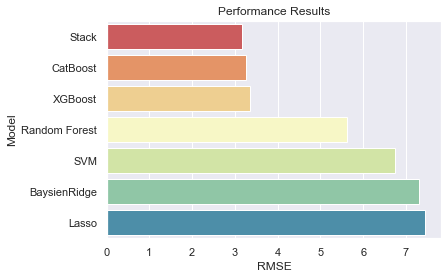

In [101]:
result = {'Model': ['Lasso','BaysienRidge','SVM','XGBoost', 'CatBoost', 'Random Forest','Stack'],
          'RMSE' : [ls_rmse, br_rmse, svm_rmse, xgb_rmse, cb_rmse, rf_rmse, stack_rmse],
          'Normalized RMSE' : [ls_nrmse, br_nrmse, svm_nrmse, xgb_nrmse, cb_nrmse, rf_nrmse, stack_nrmse],}
result_df = pd.DataFrame(result).sort_values('RMSE').sort_values(by='Normalized RMSE').reset_index(drop=True)
sns.barplot(data=result_df, y='Model', x='RMSE', palette="Spectral")
plt.title('Performance Results')
result_df

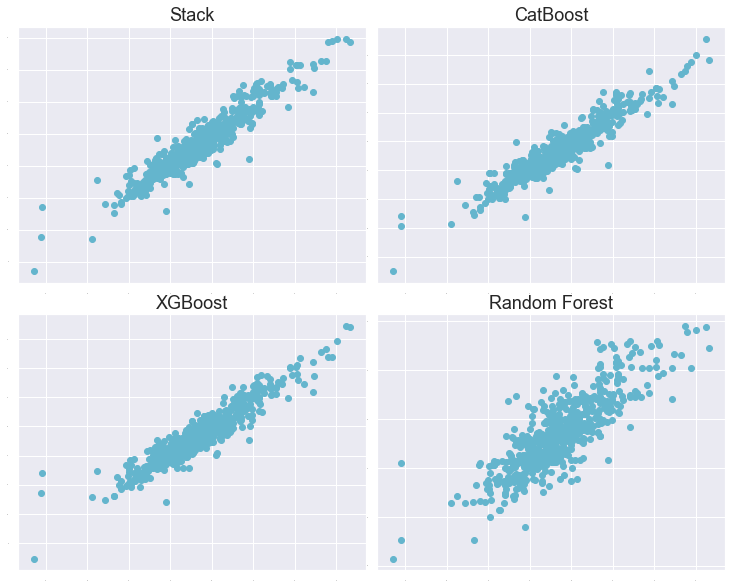

In [116]:
sns.set(font_scale=.0)
fig, ax = plt.subplots(2,2, figsize=(10,8))
y_preds = [pred_stack, pred_cb, pred_xgb, pred_rf]
models = ['Stack','CatBoost','XGBoost','Random Forest']
i = 0
for r in range(2):
    for c in range(2):
        ax[r,c].scatter(y_test, y_preds[i], color="c")
        ax[r,c].set_title(models[i], fontsize=18)
        ax[r,c].set_xlabel('')
        ax[r,c].set_ylabel('')
        i += 1
plt.tight_layout()

## Train Top Models with whole dataset

In [ ]:
X_impute.shape

In [ ]:
cb2 = CatBoostRegressor(iterations=1000, depth=5, l2_leaf_reg=3, learning_rate=0.2, loss_function='RMSE', verbose=False).fit(X_impute, y)
xgb2 = xgboost.XGBRegressor(max_depth=4, n_estimators=700, eta=0.2, grow_policy='lossguide',
                           max_leaves=5, reg_lambda=0, reg_alpha=3, eval_metric=["rmse"]).fit(X_impute, y)
rf2 = RandomForestRegressor(max_depth=5, min_samples_leaf=3, n_estimators=800).fit(X_impute, y)
estimators = [('cb', cb2),('xgb', xgb2)]
stack2 = StackingRegressor(estimators=estimators, final_estimator=rf2).fit(X_impute, y)

In [ ]:
# Save the best model
joblib.dump(cb2, '../../03_Model/cb_reg_030821.pkl', compress = 1)
joblib.dump(xgb2, '../../03_Model/xgb_reg_030821.pkl', compress = 1)
joblib.dump(stack2, '../../03_Model/stack_reg_030821_best.pkl', compress = 1)